In [2]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [3]:
!pwd

/content


In [4]:
%cd /content/drive/MyDrive/data_assign_2/hand_written_digits

/content/drive/MyDrive/data_assign_2/hand_written_digits


In [5]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [6]:
# Define directory path to your dataset
data_dir = "/content/drive/MyDrive/data_assign_2/hand_written_digits"

# Set parameters for data loader
batch_size = 32
img_height = 100
img_width = 100

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',  # 'binary' for two classes,'categorical' for multi-classes
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_width, img_height),
    batch_size=batch_size,
)


validation_data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',  # Change to 'binary' if you have two classes
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_width, img_height),
    batch_size=batch_size,
)

Found 4658 files belonging to 3 classes.
Using 3727 files for training.
Found 4658 files belonging to 3 classes.
Using 931 files for validation.


# **Transfer Leaning Models**

1) **vGG16**

In [7]:
# Load the base VGG16 model, excluding the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))



58889256/58889256 [==============================] - 0s 0us/step


In [8]:
base_model.input

<KerasTensor: shape=(None, 100, 100, 3) dtype=float32 (created by layer 'input_1')>

In [9]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

In [10]:
# Add new top layers
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(3, activation='softmax')(x)  # Assuming 3 classes:


In [11]:
# create a new model by combining pre-trained VGG16 with your own top layers
model_VGG16 = Model(inputs=base_model.input, outputs=predictions)

In [12]:
model_VGG16.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])


In [13]:
#model_VGG16.compile(optimizer='adam',
             #       loss='categorical_crossentropy',
              #      metrics=['accuracy'])


In [14]:
#model_VGG16.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(learning_rate=0.001), metrics=['accuracy'])

In [15]:
model_VGG16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [16]:
initial_epochs = 10  # Adjust as per your requirement
history = model_VGG16.fit(
    train_ds,
    validation_data=validation_data,
    epochs=initial_epochs
)


Epoch 1/10
117/117 [==============================] - 640s 5s/step - loss: 6.9111 - accuracy: 0.5299 - val_loss: 0.3963 - val_accuracy: 0.9227
Epoch 2/10
117/117 [==============================] - 598s 5s/step - loss: 2.5707 - accuracy: 0.7588 - val_loss: 0.1790 - val_accuracy: 0.9710
Epoch 3/10
117/117 [==============================] - 601s 5s/step - loss: 1.3694 - accuracy: 0.8511 - val_loss: 0.1212 - val_accuracy: 0.9796
Epoch 4/10
117/117 [==============================] - 598s 5s/step - loss: 0.8682 - accuracy: 0.8932 - val_loss: 0.1053 - val_accuracy: 0.9807
Epoch 5/10
117/117 [==============================] - 602s 5s/step - loss: 0.7230 - accuracy: 0.9206 - val_loss: 0.1016 - val_accuracy: 0.9807
Epoch 6/10
117/117 [==============================] - 601s 5s/step - loss: 0.4549 - accuracy: 0.9418 - val_loss: 0.0862 - val_accuracy: 0.9860
Epoch 7/10
117/117 [==============================] - 597s 5s/step - loss: 0.4988 - accuracy: 0.9383 - val_loss: 0.0816 - val_accuracy: 0.9871

In [17]:
# evaluate the model
val_loss, val_accuracy = model_VGG16.evaluate(validation_data)
print(f'Validation accuracy: {val_accuracy*100:.2f}%')


30/30 [==============================] - 115s 4s/step - loss: 0.0679 - accuracy: 0.9882
Validation accuracy: 98.82%


In [18]:
model_VGG16.save('/content/drive/MyDrive/VGG16_TransferLearning.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**fine tuning the model**

In [19]:
# Unfreeze some top layers of the base model
base_model.trainable = True
fine_tune_at = 100  # This is an example, adjust based on your model's architecture

# Freeze all the layers before the 'fine_tune_at' layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile the model with a lower learning rate
model_VGG16.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower learning rate
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

# Continue training
fine_tune_epochs = 5
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model_VGG16.fit(train_ds,
                               validation_data=validation_data,
                               epochs=total_epochs,
                               initial_epoch=history.epoch[-1])


Epoch 10/15
117/117 [==============================] - 609s 5s/step - loss: 0.2442 - accuracy: 0.9697 - val_loss: 0.0612 - val_accuracy: 0.9914
Epoch 11/15
117/117 [==============================] - 610s 5s/step - loss: 0.2108 - accuracy: 0.9726 - val_loss: 0.0614 - val_accuracy: 0.9936
Epoch 12/15
117/117 [==============================] - 607s 5s/step - loss: 0.1807 - accuracy: 0.9745 - val_loss: 0.0640 - val_accuracy: 0.9936
Epoch 13/15
117/117 [==============================] - 598s 5s/step - loss: 0.1973 - accuracy: 0.9767 - val_loss: 0.0636 - val_accuracy: 0.9936
Epoch 14/15
117/117 [==============================] - 601s 5s/step - loss: 0.1083 - accuracy: 0.9852 - val_loss: 0.0618 - val_accuracy: 0.9936
Epoch 15/15
117/117 [==============================] - 587s 5s/step - loss: 0.1253 - accuracy: 0.9799 - val_loss: 0.0613 - val_accuracy: 0.9936


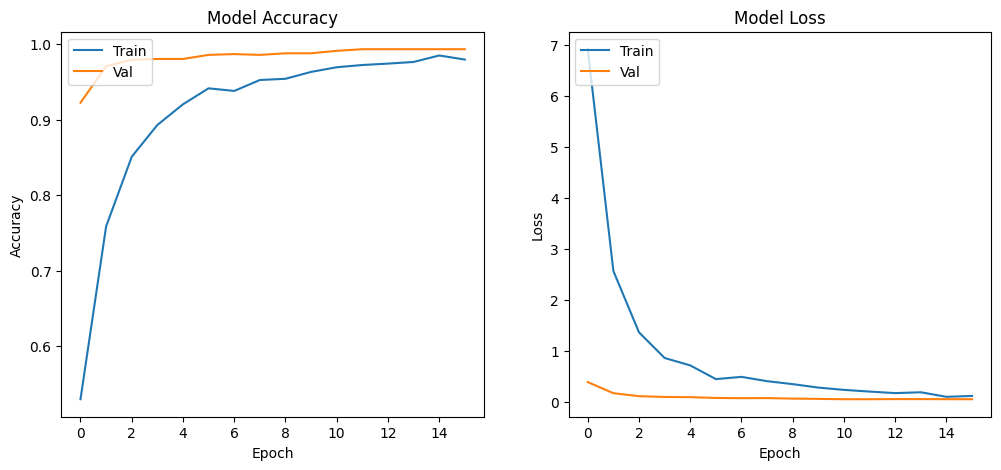

In [20]:
import matplotlib.pyplot as plt

# Combine the history from initial training and fine-tuning
total_history = {
    'accuracy': history.history['accuracy'] + history_fine.history['accuracy'],
    'val_accuracy': history.history['val_accuracy'] + history_fine.history['val_accuracy'],
    'loss': history.history['loss'] + history_fine.history['loss'],
    'val_loss': history.history['val_loss'] + history_fine.history['val_loss'],
}

plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(total_history['accuracy'])
plt.plot(total_history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(total_history['loss'])
plt.plot(total_history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.show()
